# IA for HumanForYou

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

* Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

* Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

* Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

### Données fournies

Un certain nombre de données concernant les employés vous a donc été transmis par le service des ressources humaines.

Il s'agit de fichiers textes au format CSV.

Les données ont été anonymisées : un employé de l'entreprise sera représenté par le même EmployeeID dans l'ensemble des fichiers qui suivent.

### Données du service des ressources humaines

Pour chaque employé, le service des ressources humaines vous confie les informations en sa possession :

 - Age : L'âge de l'employé en 2015.

 - Attrition : L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?

 - BusinessTravel : A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)

 - DistanceFromHome : Distance en km entre le logement de l'employé et l'entreprise.

 - Education : Niveau d'étude : 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).

 - EducationField : Domaine d'étude, matière principale

 - EmployeeCount : booléen à 1 si l'employé était compté dans les effectifs en 2015.

 - EmployeeId : l'identifiant d'un employé

 - Gender : Sexe de l'employé

 - JobLevel : Niveau hiérarchique dans l'entreprise de 1 à 5

 - JobRole : Métier dans l'entreprise

 - MaritalStatus : Statut marital du salarié (Célibataire, Marié ou Divorcé).

 - MonthlyIncome : Salaire brut en roupies par mois

 - NumCompaniesWorked : Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.

 - Over18 : Est-ce que le salarié a plus de 18 ans ou non ?

 - PercentSalaryHike : % d'augmentation du salaire en 2015.

 - StandardHours : Nombre d'heures par jour dans le contrat du salarié.

 - StockOptionLevel : Niveau d'investissement en actions de l'entreprise par le salarié.

 - TotalWorkingYears : Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.

 - TrainingTimesLastYear : Nombre de jours de formation en 2015

 - YearsAtCompany : Ancienneté dans l'entreprise

 - YearsSinceLastPromotion : Nombre d'années depuis la dernière augmentation individuelle

 - YearsWithCurrentManager : Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

### Importation des données utiles 

In [2]:
import os
import tarfile
import zipfile
import urllib.request
from six.moves import urllib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import seaborn as sns

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(42) 


DOWNLOAD_ROOT = "https://github.com/Killian-drh/Projet-IA/raw/main/datasets/inoutime/"
INOUTPATH = os.path.join("datasets", "inoutime")
DATA_PATH = "./datasets/"
INOUTIME_URL = DOWNLOAD_ROOT + "in_out_time.zip"

def check_image_folder():
    if not os.path.exists("./images/"):
        os.makedirs("./images/")
        os.makedirs("./images/workflowDS/")
        print ("Images and workflowDS folder has been created")
    elif os.path.exists("./images/"):
        if not os.path.exists("./images/workflowDS/"):
            os.makedirs("./images/workflowDS/")
            print ("WorkflowDS folder has been created")


def fetch_inoutime_data(inoutime_url=INOUTIME_URL, data_path=INOUTPATH):
    in_out_time_check = data_path + "/in_out_time.zip"
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
    if not os.path.exists(in_out_time_check):
        # Download in_out_time.zip from repo github
        zip_path = os.path.join(data_path, "in_out_time.zip")
        urllib.request.urlretrieve(inoutime_url, zip_path)    
        print ("Download Succeed !")

    # specifying the zip file name 
    file_name = './datasets/inoutime/in_out_time.zip'
    
    in_time_check = os.path.exists("./datasets/inoutime/in_time.csv")
    out_time_check = os.path.exists("./datasets/inoutime/out_time.csv")
    
    if in_time_check==False or out_time_check==False: 
    # opening the zip file in READ mode 
        with zipfile.ZipFile(file_name, 'r') as zip: 
          #  printing all the contents of the zip file 
            zip.printdir() 
  
        # extracting all the files 
            print('Extracting all the files now...') 
            zip.extractall(data_path) 
            print('Done!') 
            
    print("Process succeed")
    
check_image_folder()
fetch_inoutime_data()

def load_data(file, data_path=DATA_PATH):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path)

general_data = load_data("general_data.csv")
manager_survey_data = load_data("manager_survey_data.csv")
employee_survey_data = load_data("employee_survey_data.csv")
intime_data = pd.read_csv("./datasets/inoutime/in_time.csv")
outtime_data = pd.read_csv("./datasets/inoutime/out_time.csv")

Process succeed


### Fusion des DataFrame

In [3]:
print(general_data.shape ,  manager_survey_data.shape ,  employee_survey_data.shape)
print(manager_survey_data.columns.tolist())
print(employee_survey_data.columns.tolist())

(4410, 24) (4410, 3) (4410, 4)
['EmployeeID', 'JobInvolvement', 'PerformanceRating']
['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']


In [4]:
df_merge=pd.merge(general_data,manager_survey_data,on='EmployeeID')
df=pd.merge(df_merge,employee_survey_data,on='EmployeeID')


if(len(df.columns.tolist())   == (len(general_data.columns.tolist()) + len(employee_survey_data.columns.tolist()) + len(manager_survey_data.columns.tolist())) - 2):
  print("OK")

OK


In [5]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


### Calcul du temps moyen d'un employé passé au travail

In [6]:
intime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [7]:
intime_data.shape

(4410, 262)

In [8]:
intime_data=intime_data.replace(np.nan, 0)
intime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,0.0,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,0,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,0.0,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,0.0,2015-01-02 10:15:44,2015-01-05 10:21:05,0,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,0,0.0,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,0.0,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,0.0,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,0.0,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,0.0,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,0.0,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,0.0,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [9]:
intime_data.iloc[:, 1:] = intime_data.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
intime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,1970-01-01,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,1970-01-01 00:00:00,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,1970-01-01,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,1970-01-01,2015-01-02 10:15:44,2015-01-05 10:21:05,1970-01-01 00:00:00,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,1970-01-01 00:00:00,1970-01-01,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,1970-01-01,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,1970-01-01,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,1970-01-01,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,1970-01-01,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,1970-01-01,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,1970-01-01,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [10]:
outtime_data=outtime_data.replace(np.nan,0)
outtime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,0.0,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,0,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,0.0,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,0.0,2015-01-02 18:22:17,2015-01-05 17:48:22,0,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,0,0.0,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,0.0,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,0.0,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,0.0,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,0.0,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,0.0,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,0.0,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [11]:
outtime_data.iloc[:, 1:] = outtime_data.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
outtime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,1970-01-01,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,1970-01-01 00:00:00,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,1970-01-01,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,1970-01-01,2015-01-02 18:22:17,2015-01-05 17:48:22,1970-01-01 00:00:00,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,1970-01-01 00:00:00,1970-01-01,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,1970-01-01,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,1970-01-01,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,1970-01-01,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,1970-01-01,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,1970-01-01,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,1970-01-01,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [12]:
intime_data=intime_data.append(outtime_data)
intime_data.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,1970-01-01,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,1970-01-01 00:00:00,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,1970-01-01,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,1970-01-01,2015-01-02 10:15:44,2015-01-05 10:21:05,1970-01-01 00:00:00,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,1970-01-01 00:00:00,1970-01-01,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,1970-01-01,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,1970-01-01,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,1970-01-01,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,1970-01-01,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,1970-01-01,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,1970-01-01,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [13]:
intime_data=intime_data.diff(periods=4410)
intime_data=intime_data.iloc[4410:]
intime_data.reset_index(inplace=True)
intime_data.head()

,index,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,0,0.0,0 days,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,...,0 days 00:00:00,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,0 days,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49
1,1,0.0,0 days,0 days 08:06:33,0 days 07:27:17,0 days 00:00:00,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,...,0 days 07:54:11,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,0 days 00:00:00,0 days,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38
2,2,0.0,0 days,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,...,0 days 06:47:09,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,0 days,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11
3,3,0.0,0 days,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,...,0 days 07:37:45,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,0 days,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59
4,4,0.0,0 days,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,...,0 days 07:54:13,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,0 days,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05


In [14]:
intime_data.drop(columns=['index','Unnamed: 0'],axis=1,inplace=True)
intime_data.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,0 days,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,0 days,...,0 days 00:00:00,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,0 days,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49
1,0 days,0 days 08:06:33,0 days 07:27:17,0 days 00:00:00,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,0 days 07:16:44,0 days,...,0 days 07:54:11,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,0 days 00:00:00,0 days,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38
2,0 days,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,0 days 06:59:59,0 days,...,0 days 06:47:09,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,0 days,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11
3,0 days,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,0 days 07:18:23,0 days,...,0 days 07:37:45,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,0 days,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59
4,0 days,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,0 days 08:15:26,0 days,...,0 days 07:54:13,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,0 days,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05


In [15]:
intime_data.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
             '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
              '2015-11-09','2015-11-10','2015-11-11','2015-12-25'
             ], axis = 1,inplace=True) 

In [16]:
intime_data.head()

,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,...,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,0 days 07:20:49,0 days 07:16:03,...,0 days 00:00:00,0 days 00:00:00,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49
1,0 days 08:06:33,0 days 07:27:17,0 days 00:00:00,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,0 days 07:16:44,0 days 07:36:47,0 days 07:43:39,...,0 days 07:55:42,0 days 07:54:11,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,0 days 00:00:00,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38
2,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,0 days 06:59:59,0 days 07:26:18,0 days 07:12:37,...,0 days 07:13:06,0 days 06:47:09,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11
3,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,0 days 07:18:23,0 days 06:52:36,0 days 06:54:28,...,0 days 07:27:21,0 days 07:37:45,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59
4,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,0 days 08:15:26,0 days 08:15:36,0 days 08:24:13,...,0 days 08:19:12,0 days 07:54:13,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05


In [17]:
intime_data['Actual Time']=intime_data.mean(axis=1)
intime_data['Actual Time'].head()

0   0 days 06:52:12.823293172
1   0 days 07:18:57.493975903
2   0 days 06:48:57.891566265
3   0 days 06:47:21.172690763
4   0 days 07:52:39.220883534
Name: Actual Time, dtype: timedelta64[ns]

In [18]:
intime_data['hrs']=intime_data['Actual Time']/np.timedelta64(1, 'h')
intime_data.head()

,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,...,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31,Actual Time,hrs
0,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,0 days 07:20:49,0 days 07:16:03,...,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49,0 days 06:52:12.823293172,6.870229
1,0 days 08:06:33,0 days 07:27:17,0 days 00:00:00,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,0 days 07:16:44,0 days 07:36:47,0 days 07:43:39,...,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,0 days 00:00:00,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38,0 days 07:18:57.493975903,7.315971
2,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,0 days 06:59:59,0 days 07:26:18,0 days 07:12:37,...,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11,0 days 06:48:57.891566265,6.816081
3,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,0 days 07:18:23,0 days 06:52:36,0 days 06:54:28,...,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59,0 days 06:47:21.172690763,6.789215
4,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,0 days 08:15:26,0 days 08:15:36,0 days 08:24:13,...,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05,0 days 07:52:39.220883534,7.877561


In [19]:
intime_data.reset_index(inplace=True)
intime_data.head()

,index,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,...,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31,Actual Time,hrs
0,0,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,0 days 07:20:49,...,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49,0 days 06:52:12.823293172,6.870229
1,1,0 days 08:06:33,0 days 07:27:17,0 days 00:00:00,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,0 days 07:16:44,0 days 07:36:47,...,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,0 days 00:00:00,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38,0 days 07:18:57.493975903,7.315971
2,2,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,0 days 06:59:59,0 days 07:26:18,...,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11,0 days 06:48:57.891566265,6.816081
3,3,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,0 days 07:18:23,0 days 06:52:36,...,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59,0 days 06:47:21.172690763,6.789215
4,4,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,0 days 08:15:26,0 days 08:15:36,...,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05,0 days 07:52:39.220883534,7.877561


In [21]:
intime_data.drop(intime_data.columns.difference(['index','hrs']), 1, inplace=True)
intime_data.rename(columns={'index': 'EmployeeID'},inplace=True)
intime_data.head()

,EmployeeID,hrs
0,0,6.870229
1,1,7.315971
2,2,6.816081
3,3,6.789215
4,4,7.877561


### Analyse des données

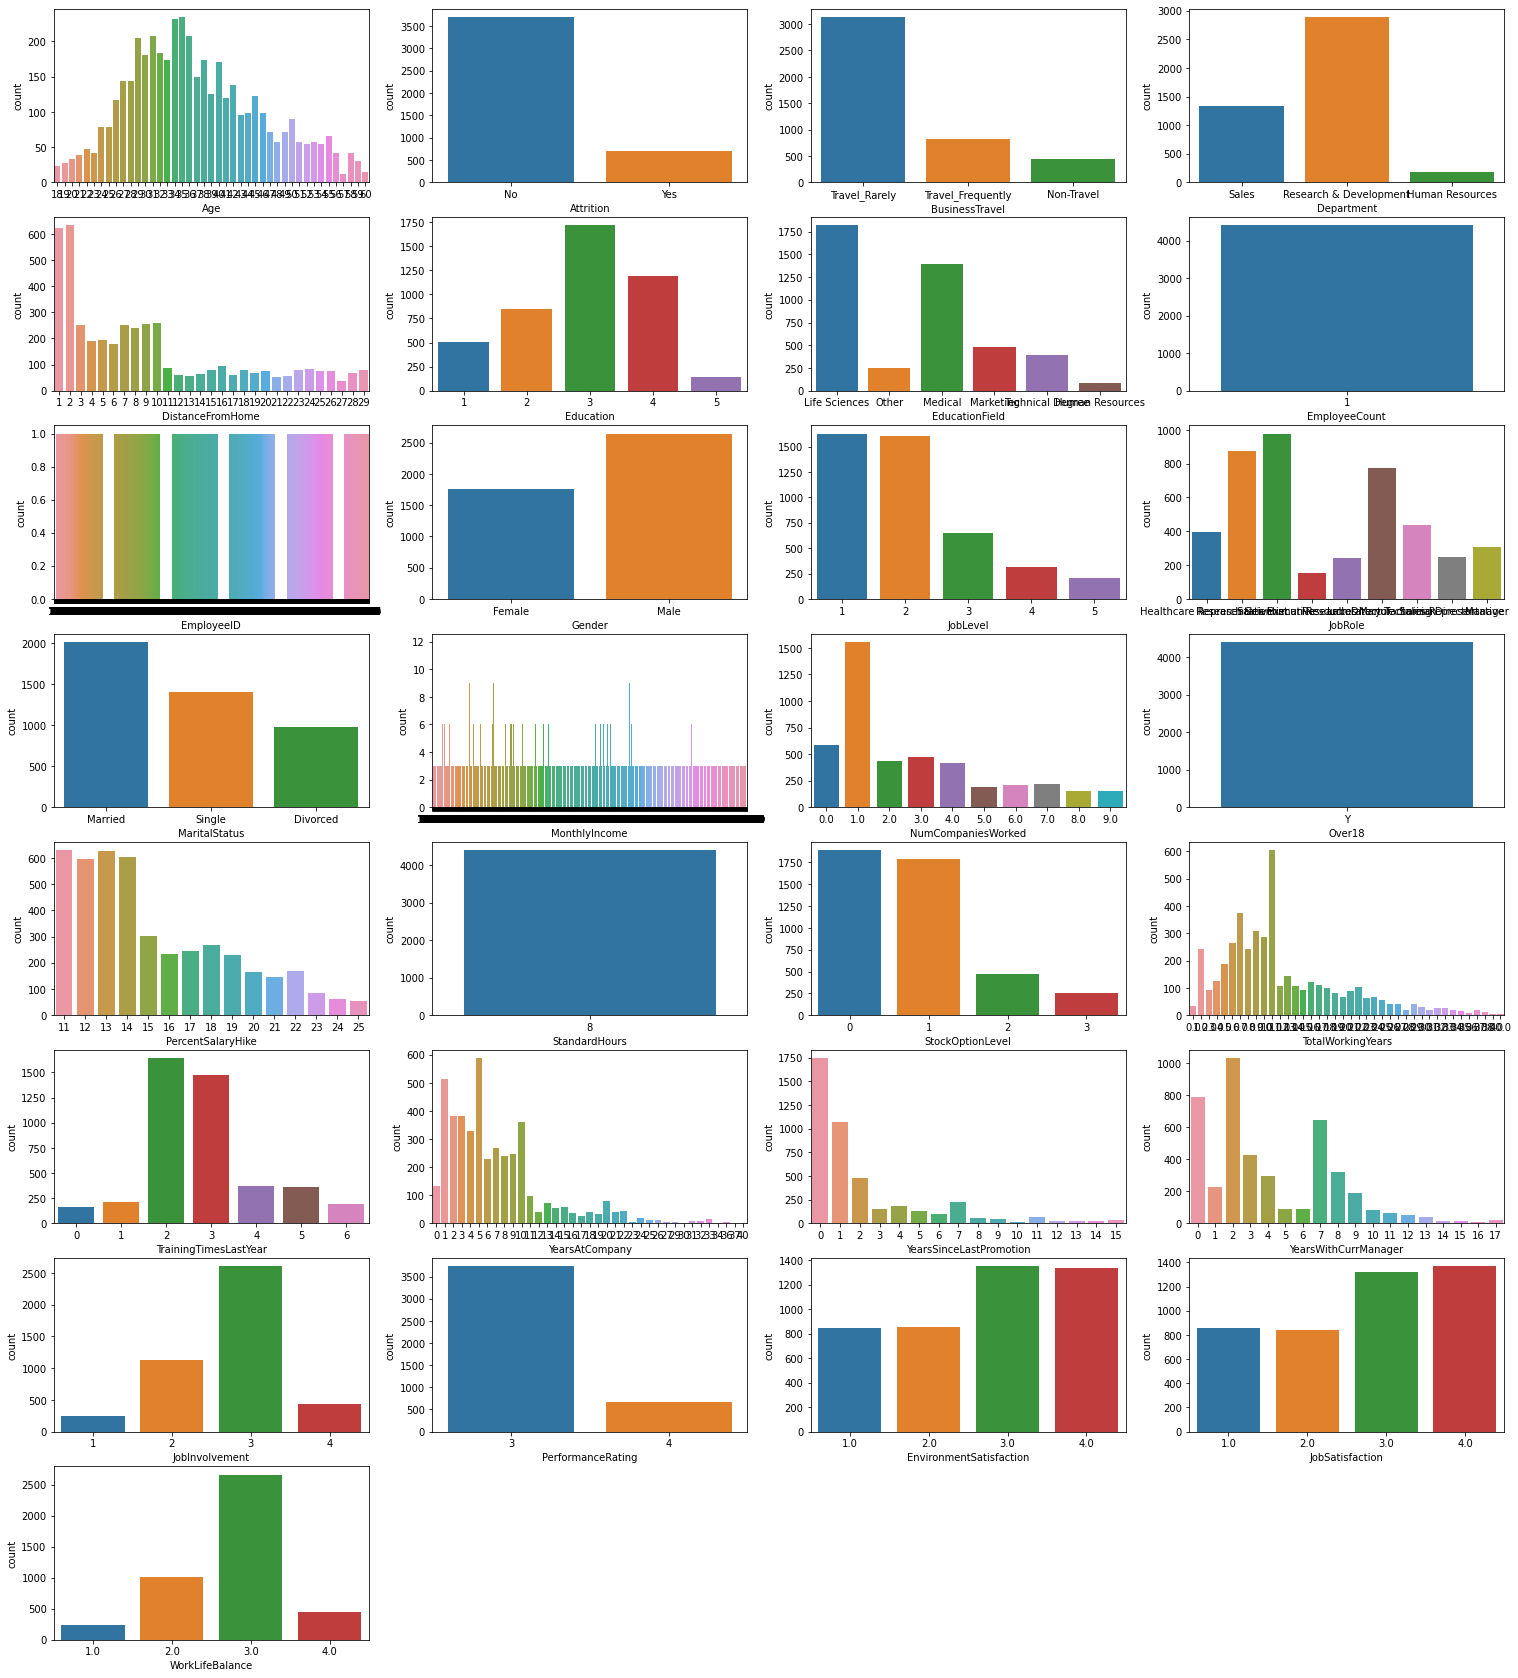

In [13]:
#For all columns doing countplots
fig = plt.figure(figsize=(26,30))
for idx,i in enumerate(df.columns.tolist()):
    ax=plt.subplot(8,4,idx+1)
    sns.countplot(x=i,data=df,ax=ax)
plt.show()